In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import albumentations as album
import random
import tqdm as tqdm
import seaborn as sns
import torch
from torch.utils.data import Dataset
import rasterio
from rasterio.windows import Window
import numpy as np
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import warnings
import albumentations as A
warnings.filterwarnings("ignore")
import segmentation_models_pytorch as smp
import glob
import gc
import pickle
from shapely.geometry import Polygon
import geopandas as gpd
from shapely.geometry import Polygon
import pyclipper
from torch.nn import BCEWithLogitsLoss
from segmentation_models_pytorch.losses import DiceLoss
import tifffile
from rasterio.transform import from_origin

C:\Users\georg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
DATA_DIR = 'Dataset'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_mask')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_mask')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_mask')

In [3]:
class_names = ['background', 'building']

class_rgb_values = [[0, 0, 0], [255, 255, 255]]

select_classes = ['background', 'building']
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values = np.array(class_rgb_values)[select_class_indices]

print('Class Names: ', select_classes)
print('Class RGB values: ', select_class_rgb_values)

Class Names:  ['background', 'building']
Class RGB values:  [[  0   0   0]
 [255 255 255]]


In [4]:
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [5]:
class BuildingsDataset(torch.utils.data.Dataset):  
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask

    def get_filename(self, idx):
        return os.path.basename(self.image_paths[idx])
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

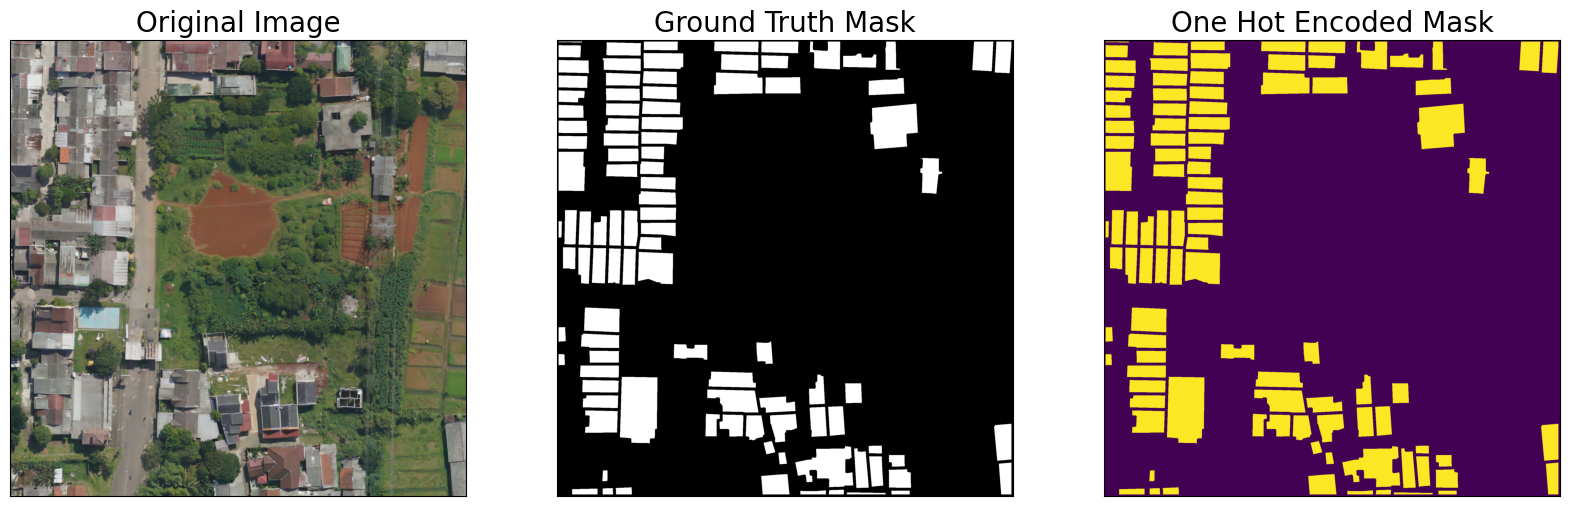

In [6]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [7]:
def get_training_augmentation():
    train_transform = [
        A.RandomCrop(height=2048, width=2048, always_apply=True),

        A.OneOf([
            A.HorizontalFlip(p=1),
            A.VerticalFlip(p=1),
            A.RandomRotate90(p=1),
        ], p=0.75),

        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),

        A.RandomBrightnessContrast(p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        A.Blur(blur_limit=3, p=0.2),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        A.CenterCrop(height=2048, width=2048, always_apply=True),
    ]
    return A.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

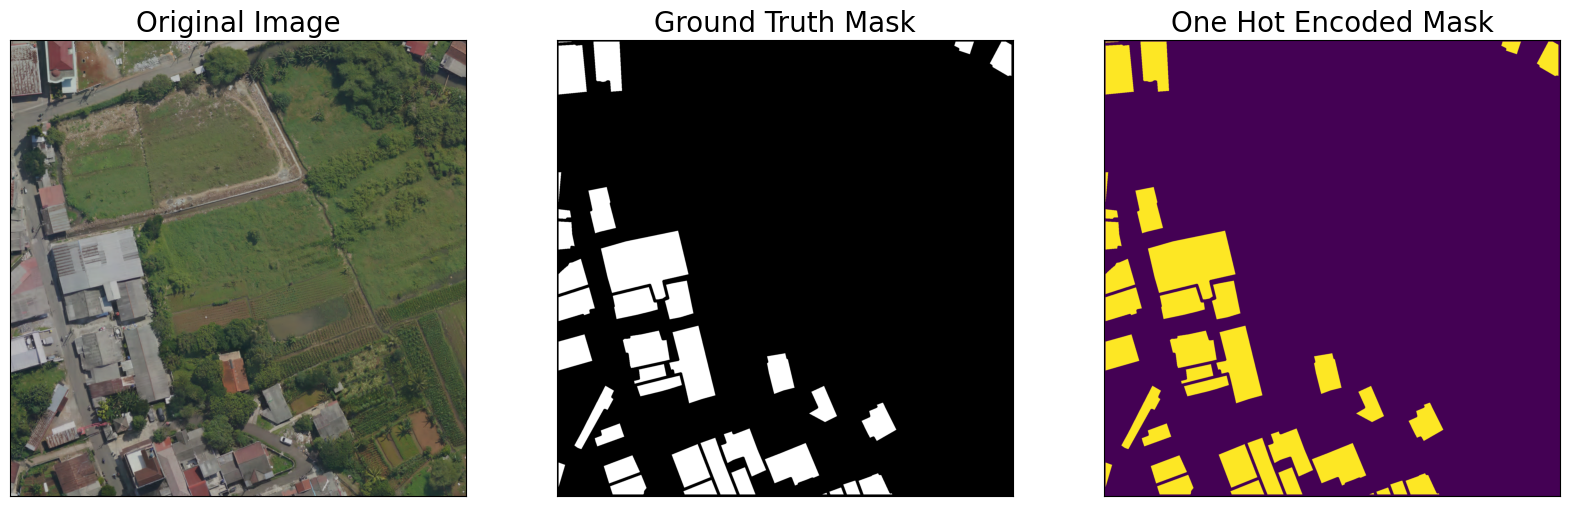

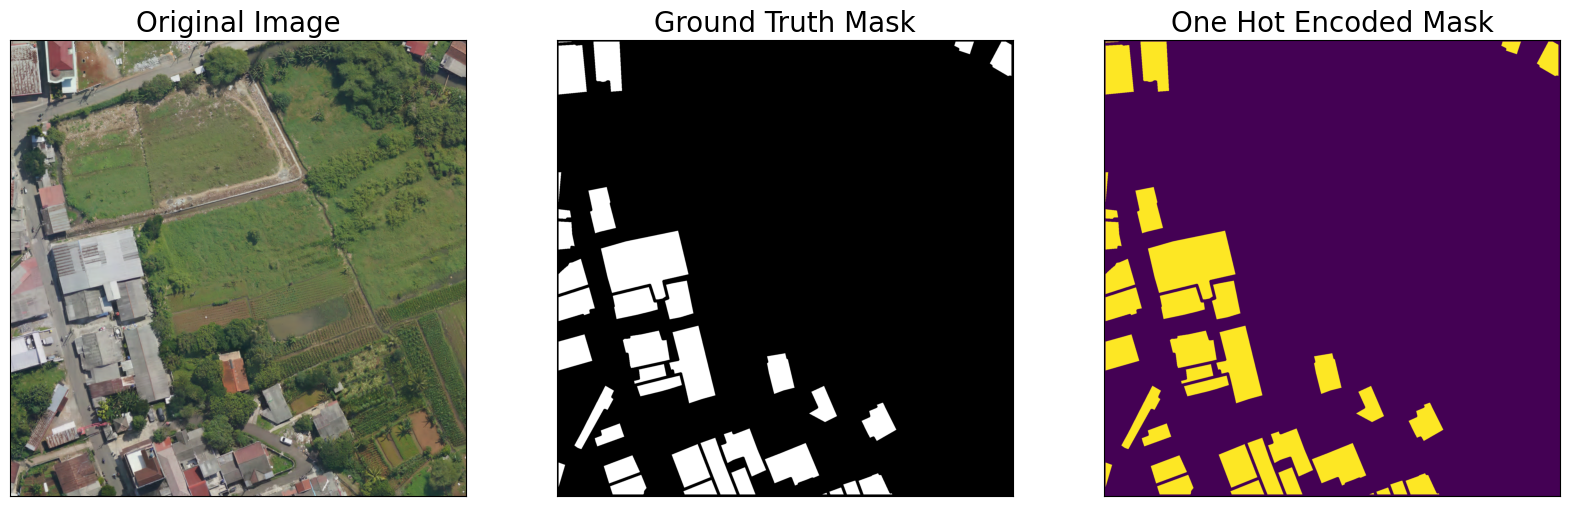

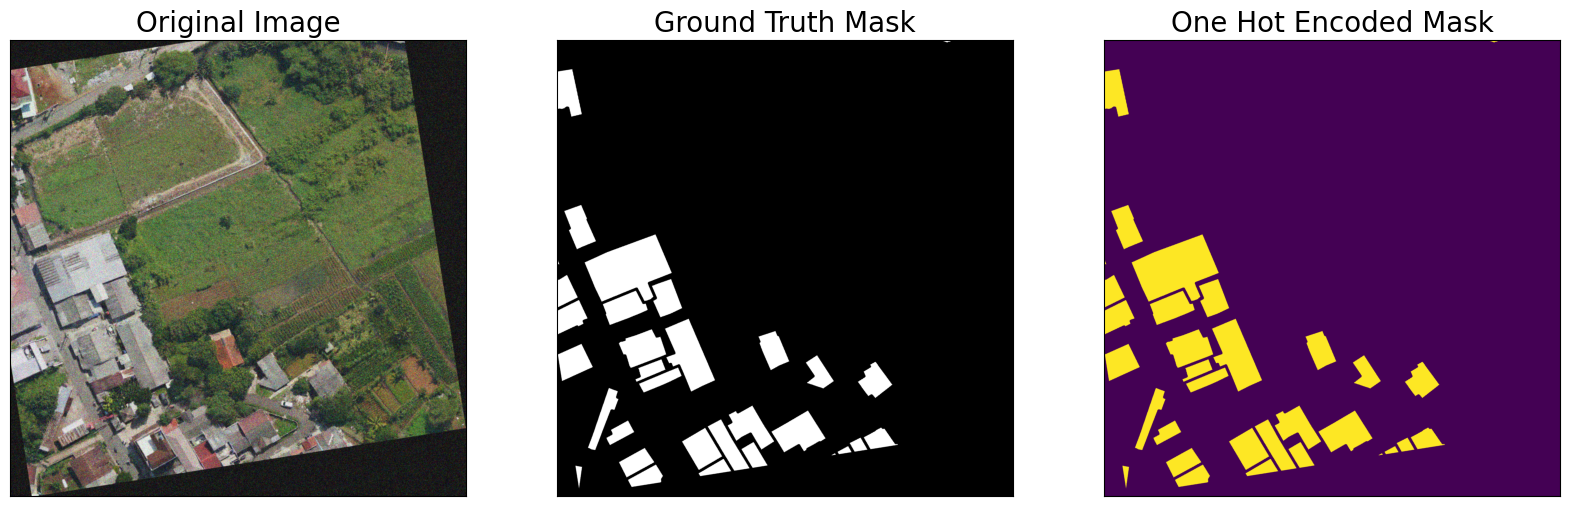

In [8]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [9]:
import segmentation_models_pytorch as smp

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x
    

# Get UNet model
model = smp.Unet(
    encoder_name="resnet50",     
    encoder_weights="imagenet",  
    in_channels=3,                
    classes=2,                    
)

In [11]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [12]:
import segmentation_models_pytorch.utils
from torch.serialization import add_safe_globals
add_safe_globals([UNet])

In [13]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = smp.losses.DiceLoss(mode='binary')

    def forward(self, y_pred, y_true):
        return self.bce(y_pred, y_true) + self.dice(y_pred, y_true)

In [14]:
# Set flag to train the model or not
TRAINING = True

# Set num of epochs
EPOCHS = 30

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

# Define loss function
loss_fn = BCEDiceLoss()
loss_fn.__name__ = "BCEDiceLoss"

# Define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# Define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# === Load checkpoint if available ===
best_iou_score = 0.0
checkpoint_path = 'Semantic_model/Unetbest_model.pth'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_iou_score = checkpoint['best_iou']
    print('Checkpoint loaded successfully.')

model.to(DEVICE)

Checkpoint loaded successfully.


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [15]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss_fn,  
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss_fn,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [16]:
torch.cuda.empty_cache()
gc.collect()

4394

In [ ]:
if TRAINING:

    model.to(DEVICE)
    early_stop_counter = 0
    early_stop_patience = 5
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i+1))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        torch.save(model, f'Semantic_model/model_epoch_{i+1}.pth')
    
        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': lr_scheduler.state_dict(),
                'best_iou': best_iou_score
            }, 'Semantic_model/Unetbest_model.pth')
            print(f"Checkpoint saved with IoU: {best_iou_score:.4f}")
            early_stop_counter = 0

        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patience:
            print(f"Early stopping triggered at epoch {i+1}") # Avoid overfitting
            break

        lr_scheduler.step()
        torch.cuda.empty_cache()
        gc.collect()

with open('train_valid_logs.pkl', 'wb') as f:
    pickle.dump({'train': train_logs_list, 'valid': valid_logs_list}, f)


Epoch: 0
valid: 100%|██████████| 6/6 [01:21<00:00, 13.61s/it, BCEDiceLoss - 0.5252, iou_score - 0.8043]

Epoch: 1
valid: 100%|██████████| 6/6 [01:28<00:00, 14.69s/it, BCEDiceLoss - 0.5561, iou_score - 0.7845]

Epoch: 2
valid: 100%|██████████| 6/6 [01:26<00:00, 14.46s/it, BCEDiceLoss - 0.5097, iou_score - 0.814] 

Epoch: 3
valid: 100%|██████████| 6/6 [01:26<00:00, 14.34s/it, BCEDiceLoss - 0.5047, iou_score - 0.8161]

Epoch: 4
valid: 100%|██████████| 6/6 [01:26<00:00, 14.37s/it, BCEDiceLoss - 0.489, iou_score - 0.8229] 
Early stopping triggered at epoch 5


In [17]:
best_model = torch.load('Semantic_model/Unetbest_model.pth', map_location=DEVICE, weights_only=False)

model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None,
    in_channels=3,
    classes=2
)

model.load_state_dict(checkpoint['model_state_dict']) 
model.to(DEVICE)
model.eval()
print('Loaded UNet model')

with open('train_valid_logs.pkl', 'rb') as f:
    logs = pickle.load(f)
    train_logs_list = logs['train']
    valid_logs_list = logs['valid']

Loaded UNet model


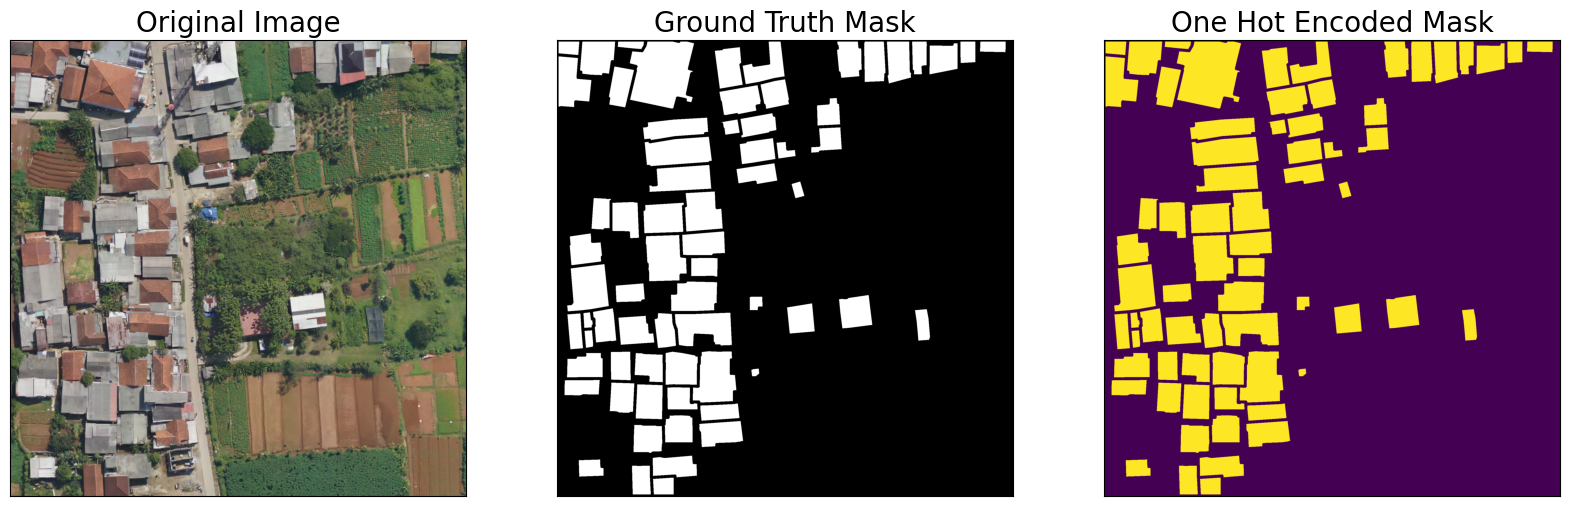

In [18]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [19]:
sample_preds_folder = 'UNET_predicted_masks/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):
    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    with torch.no_grad():
        pred_mask = model(x_tensor)

    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    pred_mask = np.transpose(pred_mask, (1, 2, 0))

    pred_building_heatmap = pred_mask[:, :, select_classes.index('building')]
    pred_mask_vis = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)

    gt_mask = np.transpose(gt_mask, (1, 2, 0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)

    if hasattr(test_dataset, 'image_paths'):
        original_filename = os.path.basename(test_dataset.image_paths[idx])
        filename_wo_ext = os.path.splitext(original_filename)[0]
        save_name = f"sample_pred_{filename_wo_ext}.png"
    else:
        filename_wo_ext = f"sample_{idx}"
        save_name = f"{filename_wo_ext}.png"

    # Save comparison image (input, GT, prediction)
    cv2.imwrite(
        os.path.join(sample_preds_folder, save_name),
        np.hstack([image_vis, gt_mask, pred_mask_vis])[:, :, ::-1]
    )

    # === Create binary mask (0 or 255) ===
    binary_mask = (pred_building_heatmap > 0.5).astype(np.uint8) * 255

    # === Save binary mask as GeoTIFF with CRS ===
    original_image_path = test_dataset.image_paths[idx]
    with rasterio.open(original_image_path) as src:
        original_crs = src.crs
        original_transform = src.transform

    output_tif_path = os.path.join(sample_preds_folder, f"{filename_wo_ext}_pred_mask.tif")
    with rasterio.open(
        output_tif_path,
        'w',
        driver='GTiff',
        height=binary_mask.shape[0],
        width=binary_mask.shape[1],
        count=1,
        dtype='uint8',
        crs=original_crs,
        transform=original_transform
    ) as dst:
        dst.write(binary_mask, 1)

In [25]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage

def postprocess_prediction(mask, area_threshold=200):
    mask = (mask > 0.5).astype(np.uint8)

    # Step 1: Morphological opening to remove noise
    kernel = np.ones((3, 3), np.uint8)
    clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    # Step 2: Remove small objects
    labeled, num = ndimage.label(clean_mask)
    sizes = ndimage.sum(clean_mask, labeled, range(num + 1))
    mask_cleaned = np.isin(labeled, np.where(sizes > area_threshold)[0]).astype(np.uint8)

    # Step 3: Distance transform
    distance = cv2.distanceTransform(mask_cleaned, cv2.DIST_L2, 5)

    # Step 4: Local maxima
    local_max_coords = peak_local_max(distance, labels=mask_cleaned)
    markers = np.zeros_like(distance, dtype=np.int32)
    for i, (r, c) in enumerate(local_max_coords):
        markers[r, c] = i + 1

    # Step 5: Watershed segmentation
    mask_rgb = np.stack([mask_cleaned]*3, axis=-1)
    markers = cv2.watershed((mask_rgb * 255).astype(np.uint8), markers)
    watershed_result = (markers > 0).astype(np.uint8)

    return watershed_result

In [26]:
for idx in range(len(test_dataset)): 
    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    with torch.no_grad():
        pred = model(x_tensor)

    pred = pred.detach().squeeze().cpu().numpy()
    pred = np.transpose(pred, (1, 2, 0))  # (H, W, C)

    pred_building_heatmap = pred[:, :, select_classes.index('building')]
    regularized_mask = postprocess_prediction(pred_building_heatmap)

    regularized_rgb = np.repeat(regularized_mask[..., np.newaxis], 3, axis=2) * 255

    if hasattr(test_dataset, 'image_paths'):
        original_filename = os.path.basename(test_dataset.image_paths[idx])
        filename_wo_ext = os.path.splitext(original_filename)[0]  # remove .tif
        save_name = f"regularized_mask_({filename_wo_ext}).png"
    else:
        save_name = f"regularized_mask_{idx}.png"

    cv2.imwrite(os.path.join(sample_preds_folder, save_name), regularized_rgb)

In [23]:
def evaluate_testing(model, dataset, dataloader, device='cuda'):
    model.eval()
    model.to(device)

    with torch.no_grad():
        for idx, (images, targets) in enumerate(dataloader):
            filename = dataset.get_filename(idx)
            image = images.to(device)
            target = targets.to(device)

            output = model(image)
            pred_mask = (output.squeeze(0) > 0.5).cpu()
            gt_mask = target.squeeze(0).cpu()

            intersection = (pred_mask & gt_mask).float().sum()
            union = (pred_mask | gt_mask).float().sum()
            iou = (intersection / union).item() if union > 0 else 0.0

            print(f"{filename}: IoU = {iou:.4f}")

In [24]:
model.eval()
ious = []
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

global_index = 0  # Tracks dataset-wide image index

for batch in tqdm.tqdm(test_dataloader):
    images, masks = batch
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

    for i in range(images.shape[0]):
        pred_mask = preds[i]
        true_mask = masks[i]

        iou = iou_metric(pred_mask.unsqueeze(0), true_mask.unsqueeze(0)).item()
        ious.append(iou)

        if hasattr(test_dataloader.dataset, 'image_paths') and isinstance(test_dataloader.dataset.image_paths, list):
            filename = os.path.basename(test_dataloader.dataset.image_paths[global_index])
        else:
            filename = f"Image_{global_index}"

        print(f"{filename} - IoU: {iou:.4f}")
        global_index += 1

# Final mean IoU
print(f"\nMean IoU over test dataset: {np.mean(ious):.4f}")

 12%|█▎        | 1/8 [00:00<00:06,  1.03it/s]

Dataset.13.tif - IoU: 0.8848


 25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

Dataset.25.tif - IoU: 0.9100


 38%|███▊      | 3/8 [00:02<00:03,  1.39it/s]

Dataset.27.tif - IoU: 0.7789


 50%|█████     | 4/8 [00:02<00:02,  1.46it/s]

Dataset.3.tif - IoU: 0.8405


 62%|██████▎   | 5/8 [00:03<00:02,  1.50it/s]

Dataset.41.tif - IoU: 0.8756


 75%|███████▌  | 6/8 [00:04<00:01,  1.51it/s]

Dataset.51.tif - IoU: 0.8435


 88%|████████▊ | 7/8 [00:04<00:00,  1.53it/s]

Dataset.54.tif - IoU: 0.9042


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

Dataset.8.tif - IoU: 0.8648

Mean IoU over test dataset: 0.8628
